<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

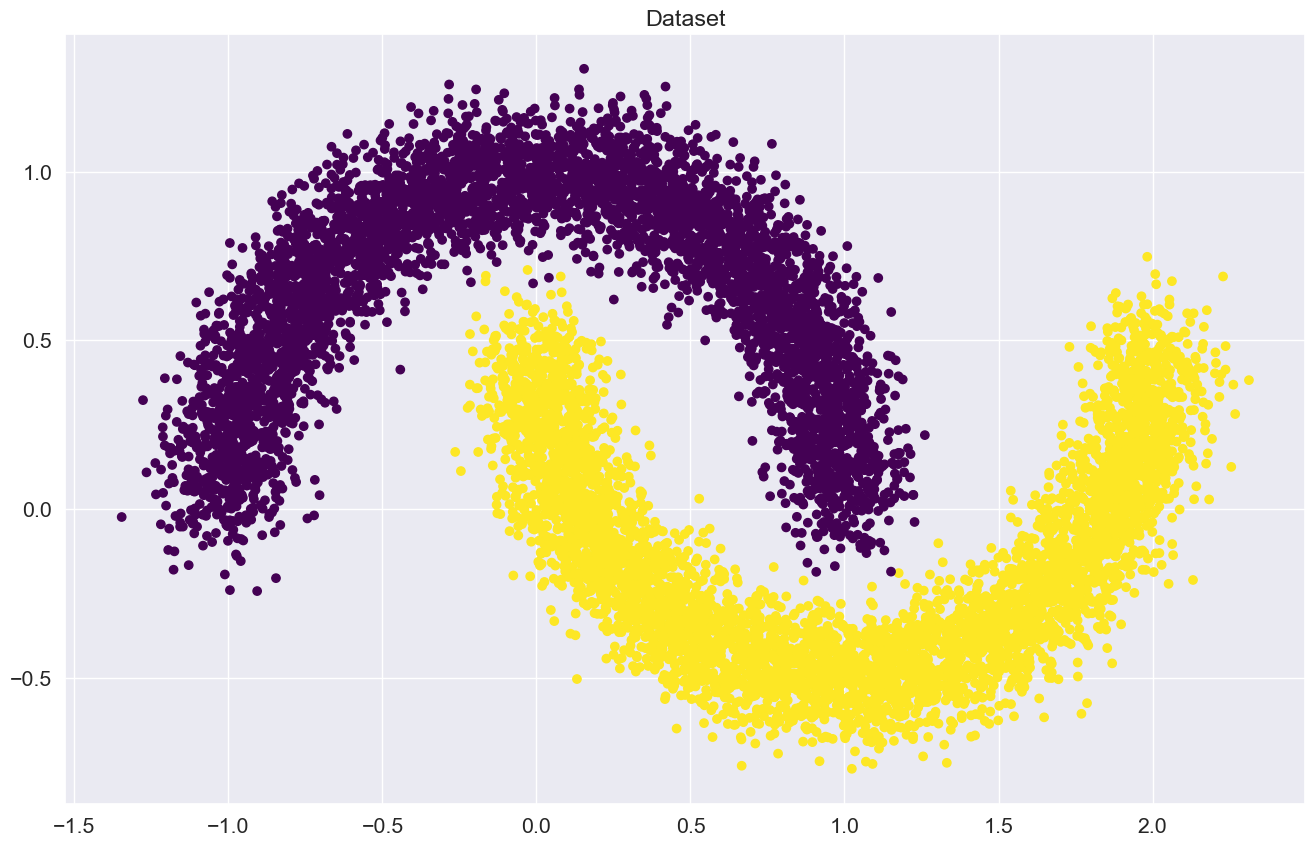

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights.T
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

число весов(включая веса в bias) = (1 + in_features) * out_features

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [9]:
from torch import sigmoid

tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch).flatten()
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.71875
Iteration: 100
Batch accuracy: 0.84375
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.90625

Iteration: 578.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:47

### Визуализируем результаты

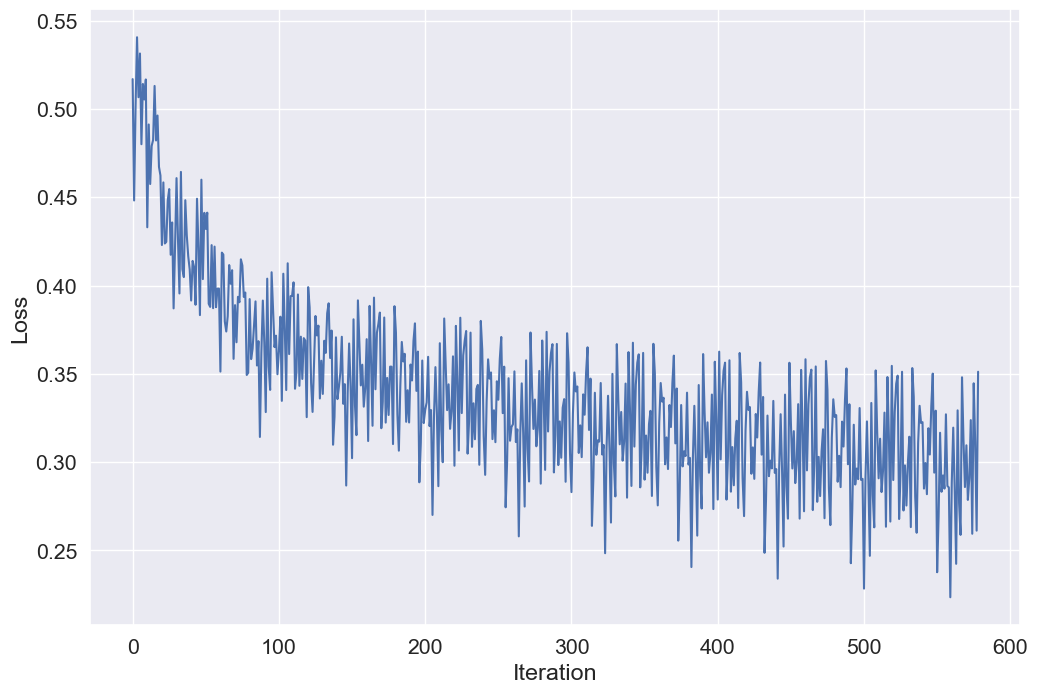

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

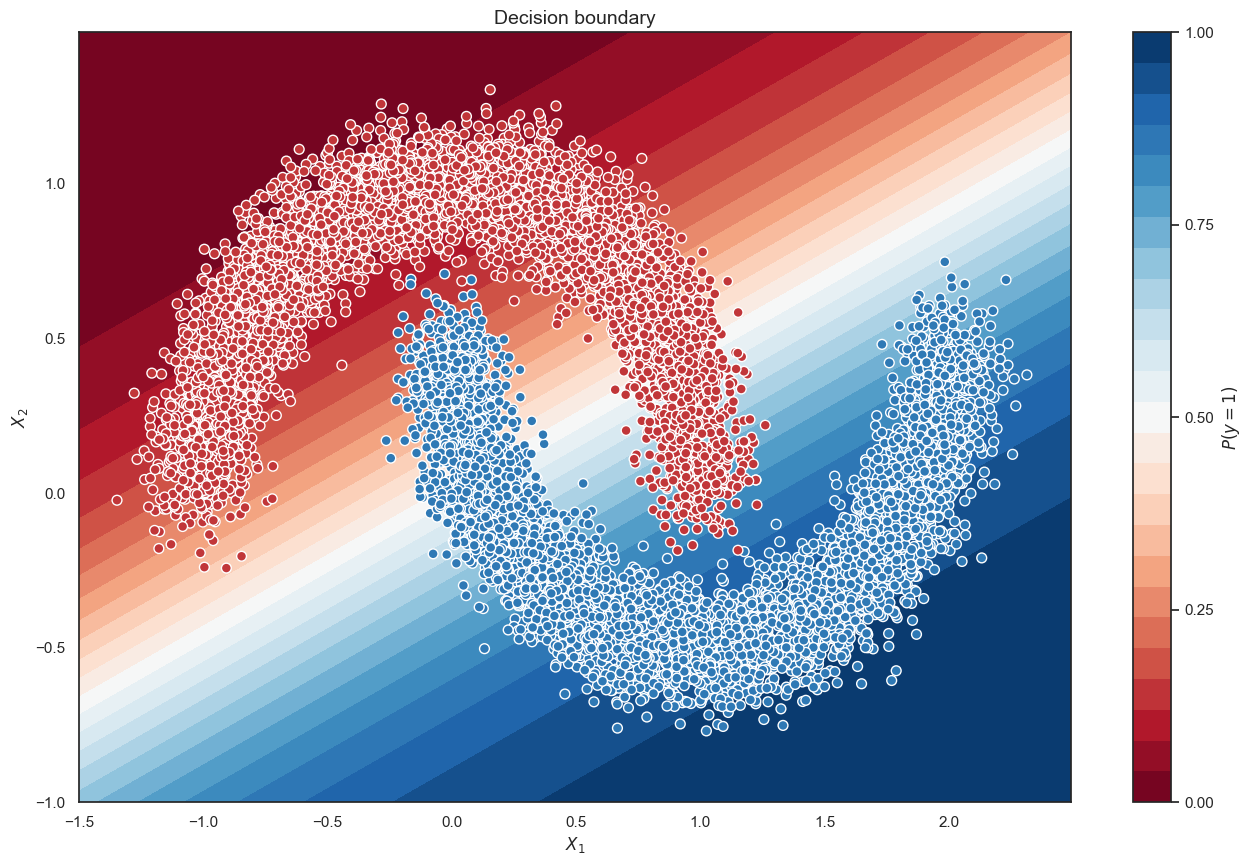

In [11]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:, 0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [12]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        nn_pred = linear_regression(x_batch).tolist()
        preds = np.array([int(x[0] > 0.5) for x in nn_pred])
        predictions = np.hstack((predictions, preds.flatten()))
    return predictions.flatten()

In [13]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)
print(accuracy_score(y_val, predictions))

0.8704


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: 0.8664**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [143]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [144]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [158]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    LinearRegression(in_features=28 * 28, out_features=128),
    activation(),
    LinearRegression(in_features=128, out_features=128),
    activation(),
    LinearRegression(in_features=128, out_features=10),
)

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [160]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [161]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            outp = []
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.7172333333333333
Loader: valid. Accuracy: 0.834
Epoch: 2
Loader: train. Accuracy: 0.8586166666666667
Loader: valid. Accuracy: 0.878
Epoch: 3
Loader: train. Accuracy: 0.888
Loader: valid. Accuracy: 0.8929
Epoch: 4
Loader: train. Accuracy: 0.9030833333333333
Loader: valid. Accuracy: 0.8977
Epoch: 5
Loader: train. Accuracy: 0.91595
Loader: valid. Accuracy: 0.9141
Epoch: 6
Loader: train. Accuracy: 0.92375
Loader: valid. Accuracy: 0.9196
Epoch: 7
Loader: train. Accuracy: 0.9315666666666667
Loader: valid. Accuracy: 0.9223
Epoch: 8
Loader: train. Accuracy: 0.9365833333333333
Loader: valid. Accuracy: 0.9284
Epoch: 9
Loader: train. Accuracy: 0.9427333333333333
Loader: valid. Accuracy: 0.9283
Epoch: 10
Loader: train. Accuracy: 0.9465333333333333
Loader: valid. Accuracy: 0.9326


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [162]:
accuracy

{'train': [0.7172333333333333,
  0.8586166666666667,
  0.888,
  0.9030833333333333,
  0.91595,
  0.92375,
  0.9315666666666667,
  0.9365833333333333,
  0.9427333333333333,
  0.9465333333333333],
 'valid': [0.834,
  0.878,
  0.8929,
  0.8977,
  0.9141,
  0.9196,
  0.9223,
  0.9284,
  0.9283,
  0.9326]}

In [163]:
elu_accuracy = accuracy["valid"]

In [164]:
def get_model(activation):
    return nn.Sequential(
        nn.Flatten(),
        LinearRegression(in_features=28 * 28, out_features=128),
        activation(),
        LinearRegression(in_features=128, out_features=128),
        activation(),
        LinearRegression(in_features=128, out_features=10),
    )

In [165]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def get_activation_for_model(cur_model):
    accuracy = {"train": [], "valid": []}
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cur_model.parameters())
    
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                outp = []
                if k == "train":
                    cur_model.train()
                    optimizer.zero_grad()
                    outp = cur_model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    cur_model.eval()
                    with torch.no_grad():
                        outp = cur_model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch + 1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
            accuracy[k].append(epoch_correct / epoch_all)
    return accuracy



In [166]:
plain_accuracy = get_activation_for_model(get_model(Identical))["valid"]
relu_accuracy = get_activation_for_model(get_model(nn.ReLU))["valid"]
leaky_relu_accuracy = get_activation_for_model(get_model(nn.LeakyReLU))["valid"]

Epoch: 1
Loader: train. Accuracy: 0.7243333333333334
Loader: valid. Accuracy: 0.8365
Epoch: 2
Loader: train. Accuracy: 0.84895
Loader: valid. Accuracy: 0.874
Epoch: 3
Loader: train. Accuracy: 0.8646333333333334
Loader: valid. Accuracy: 0.8506
Epoch: 4
Loader: train. Accuracy: 0.8710166666666667
Loader: valid. Accuracy: 0.8685
Epoch: 5
Loader: train. Accuracy: 0.8729333333333333
Loader: valid. Accuracy: 0.8828
Epoch: 6
Loader: train. Accuracy: 0.8749166666666667
Loader: valid. Accuracy: 0.894
Epoch: 7
Loader: train. Accuracy: 0.8792
Loader: valid. Accuracy: 0.883
Epoch: 8
Loader: train. Accuracy: 0.8801666666666667
Loader: valid. Accuracy: 0.8864
Epoch: 9
Loader: train. Accuracy: 0.8819166666666667
Loader: valid. Accuracy: 0.8607
Epoch: 10
Loader: train. Accuracy: 0.8802
Loader: valid. Accuracy: 0.8742
Epoch: 1
Loader: train. Accuracy: 0.69965
Loader: valid. Accuracy: 0.8339
Epoch: 2
Loader: train. Accuracy: 0.85895
Loader: valid. Accuracy: 0.8794
Epoch: 3
Loader: train. Accuracy: 0.888

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

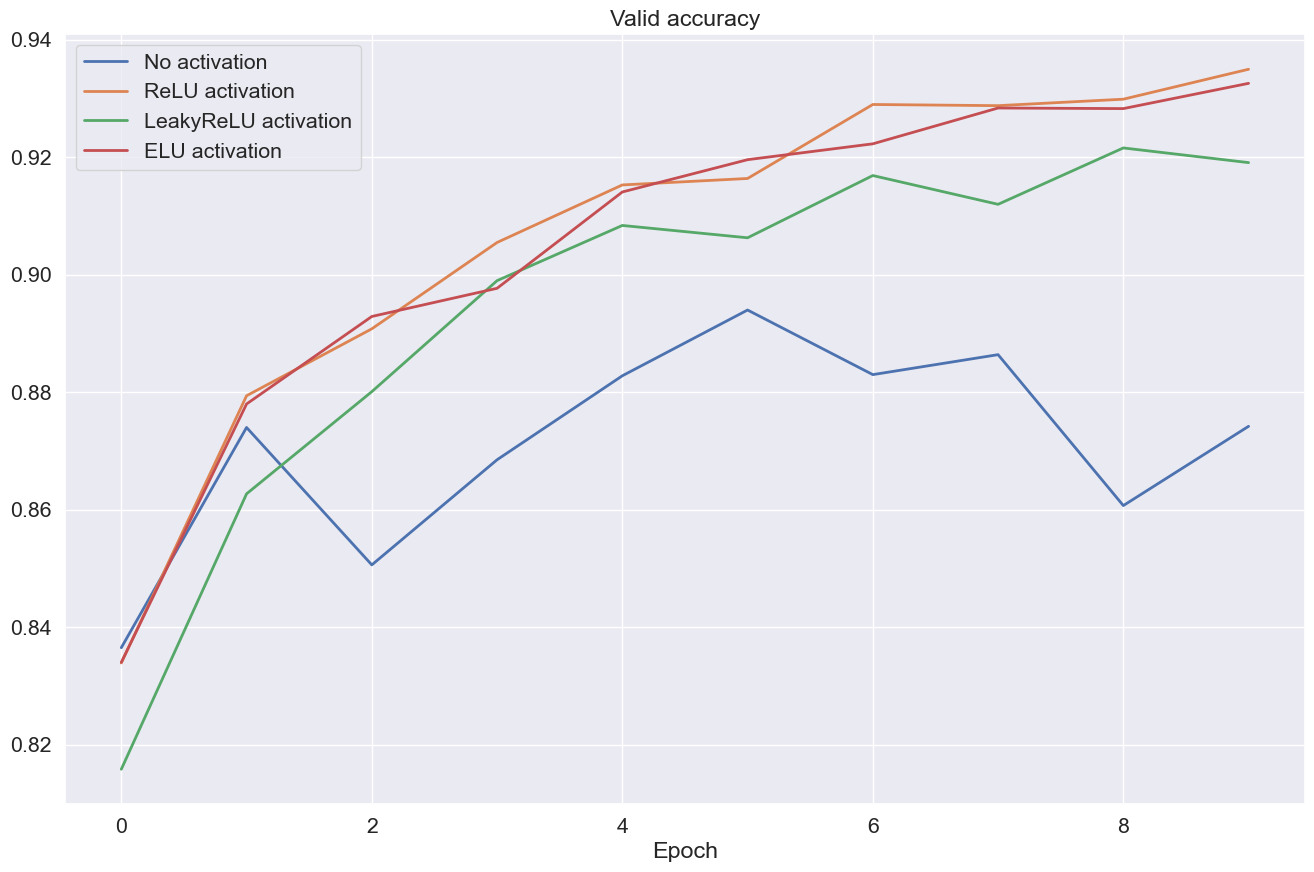

In [167]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

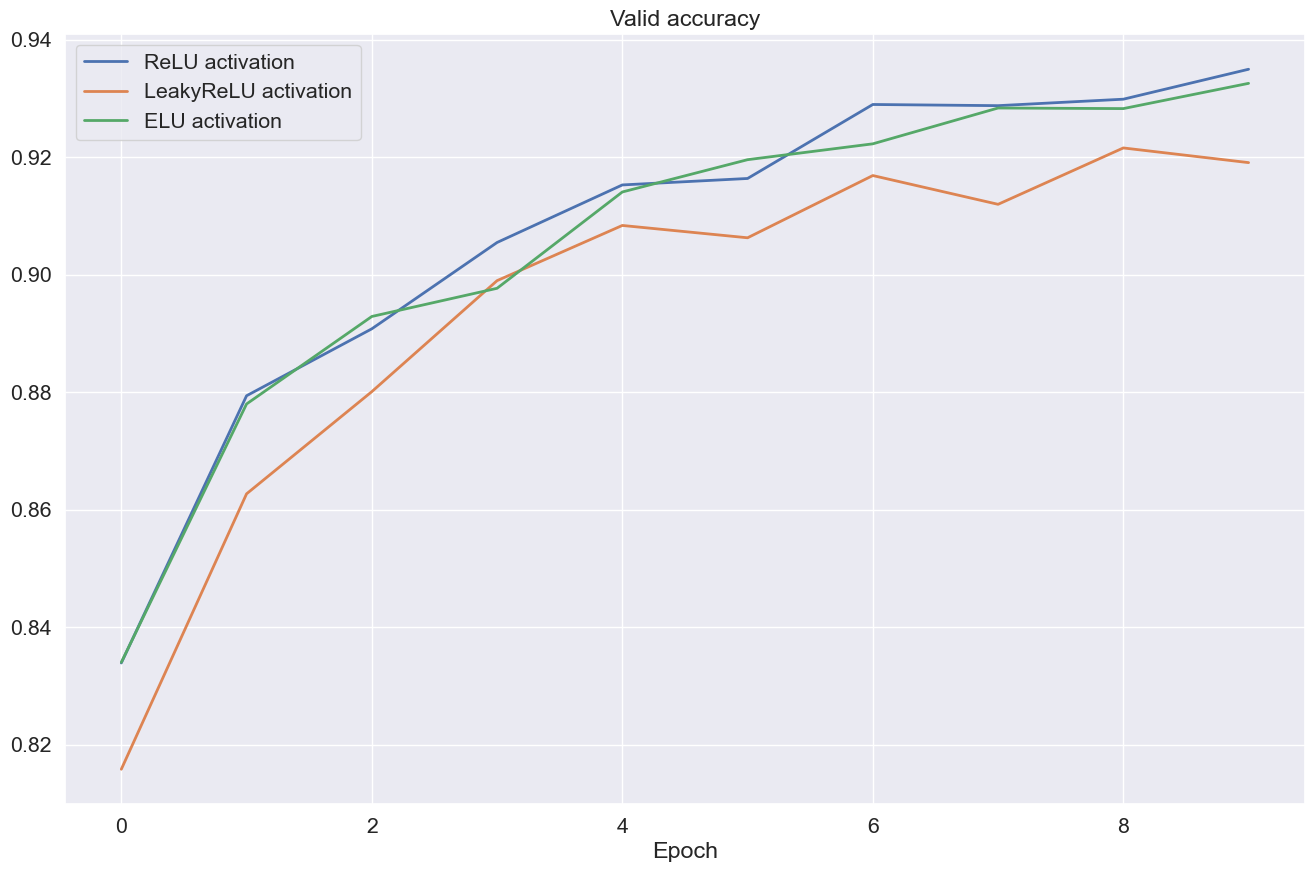

In [168]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ReLU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [30]:
!pip install wget
import wget
import cv2
url = 'https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg'
downloaded_file = wget.download(url)
img = cv2.imread(downloaded_file)

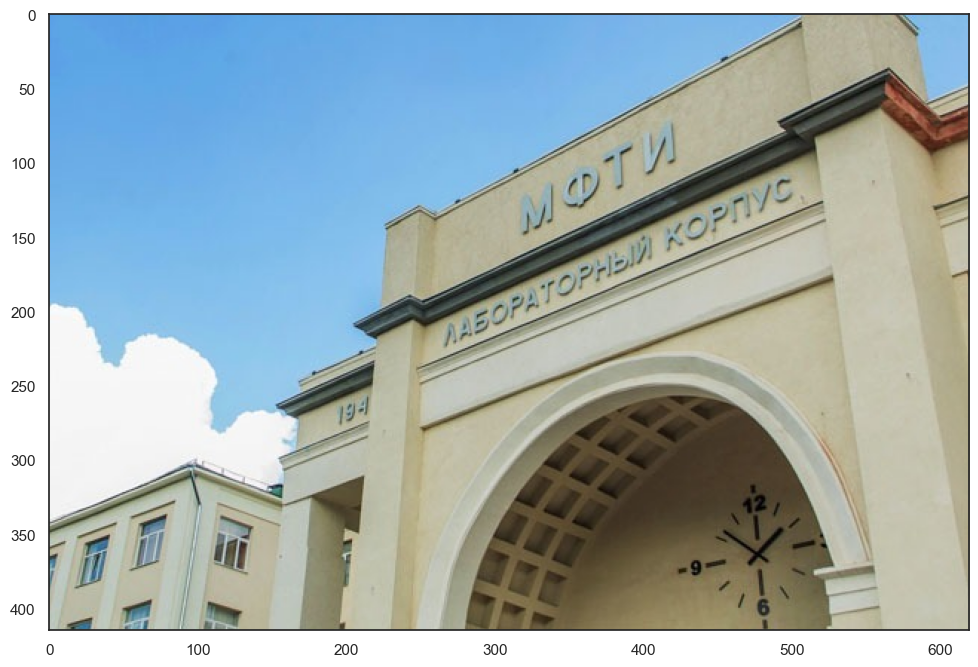

In [31]:
import cv2

sns.set(style="white")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [35]:
# Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A = [
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
]
B = [
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]
C = [
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
]
D = [
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
]
E = [
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]
F_ = [
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]


In [123]:
Rand1 = [
    [1, 0, 0], 
    [1, 1, 0], 
    [1, 1, 1]
]
Rand2 = [
    [1, 0, 1],
    [1, 0, 1],
    [1, 0, 1]
]
Rand3 = [
    [-10, -1, -3],
    [-1, 100, -1],
    [-3, -1, -10]
]
Rand4 = [
    [-1, -1, -1],
    [-1, 20, -1],
    [-1, -1, -1]
]
Rand5 = [
    [3, 3, 3],
    [3, -100, 3],
    [3, 3, 3]
]

In [127]:
from torch.nn import functional as F
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor(Rand4).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.061198..14.4973955].


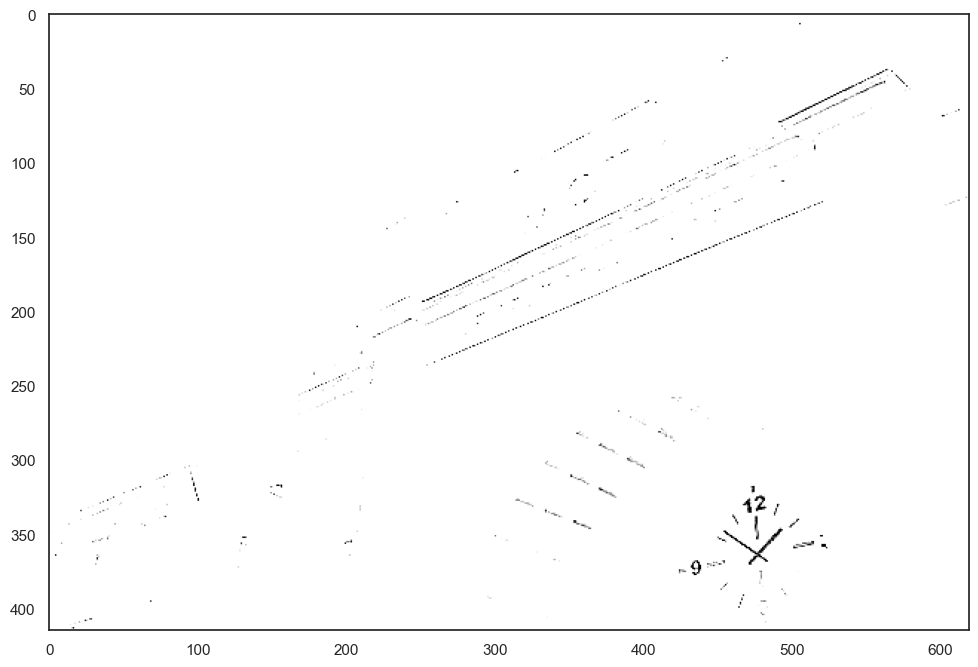

In [128]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Самый прикольный фильтр что у меня получился, чтобы оставлять яркие точки

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:
А - 3
Б - 5
В - 4
Г - 6
Д - 2
Е - 1
**

ДАННОЕ ЗАДАНИЕ ОЩУЩАЕТСЯ КАК

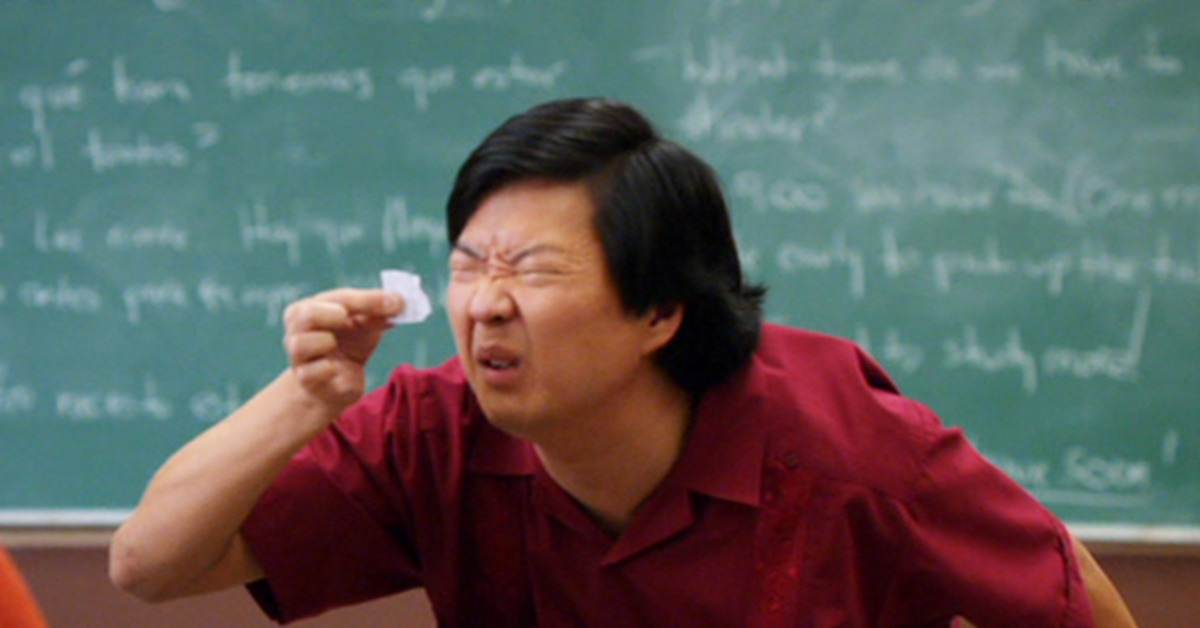

In [72]:
from IPython.display import Image
Image("C:/Users/annam/Desktop/aboba.jpg") #

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [152]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 =  nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [172]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet()

summary(net.cuda(), (1, 28, 28))

AssertionError: Torch not compiled with CUDA enabled

In [153]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [154]:
max_epochs = 10
lenet_accuracy = get_activation_for_model(LeNet())["valid"]

Epoch: 1
Loader: train. Accuracy: 0.8953
Loader: valid. Accuracy: 0.9735
Epoch: 2
Loader: train. Accuracy: 0.9728166666666667
Loader: valid. Accuracy: 0.9794
Epoch: 3
Loader: train. Accuracy: 0.9798
Loader: valid. Accuracy: 0.9816
Epoch: 4
Loader: train. Accuracy: 0.98465
Loader: valid. Accuracy: 0.9826
Epoch: 5
Loader: train. Accuracy: 0.9871166666666666
Loader: valid. Accuracy: 0.9872
Epoch: 6
Loader: train. Accuracy: 0.9887333333333334
Loader: valid. Accuracy: 0.9862
Epoch: 7
Loader: train. Accuracy: 0.9902166666666666
Loader: valid. Accuracy: 0.986
Epoch: 8
Loader: train. Accuracy: 0.9916833333333334
Loader: valid. Accuracy: 0.9839
Epoch: 9
Loader: train. Accuracy: 0.9931666666666666
Loader: valid. Accuracy: 0.9857
Epoch: 10
Loader: train. Accuracy: 0.9940833333333333
Loader: valid. Accuracy: 0.9867


In [170]:
lenet_accuracy

[0.9735, 0.9794, 0.9816, 0.9826, 0.9872, 0.9862, 0.986, 0.9839, 0.9857, 0.9867]

Сравним с предыдущем пунктом

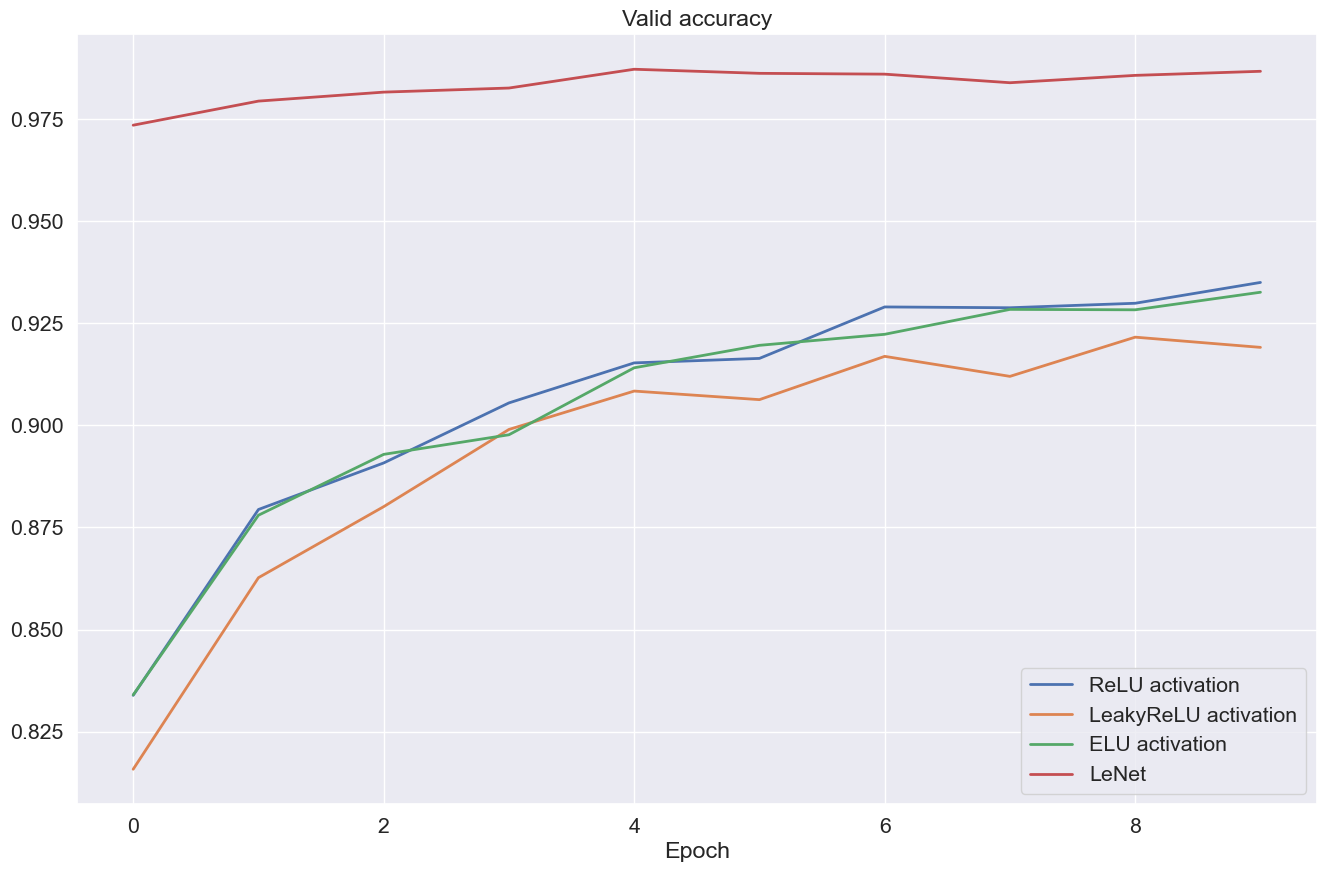

In [169]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:0.9867 (0.99 если прям округлить)**